# Fast template matching for orientation mapping of PED/NBED data

In this notebook, the fast template matching capabilities recently added to Pyxem are illustrated.
This functionality should compare and offer additional flexibility to the analysis performed in software suites like ASTAR.
Specifically, what is demonstrated:
* Generating a template library

# Requirements
As of 13/05/2021, not all the functionality in this notebook has been completely merged into stable versions of the Pyxem project.
To run it, you will need to install the development version of Pyxem, Orix and Diffsims from Github.

The following notebook should work on commit hashes:
Pyxem: 6c1ee347
Orix: 13ff938
Diffsims: 9de2e7f

In [226]:
!pwd

/Users/nielscautaerts/Documents/PythonProjects/ZZZJupyterNotebook/201126ActiveLearning4DSTEM


In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams["image.cmap"] = "gray"

# Loading data

In [4]:
import hyperspy.api as hs

experimental_data = hs.load("data/subset_data.hspy")
experimental_data.axes_manager

/Users/nielscautaerts/Documents/PythonProjects/FORKS/hyperspy/hyperspy/misc/utils.py:493: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn('Use of the `binned` attribute in metadata is '
/Users/nielscautaerts/Documents/PythonProjects/FORKS/hyperspy/hyperspy/io.py:516: UserWarning: Loading old file version. The binned attribute has been moved from metadata.Signal to axis.is_binned. Setting this attribute for all signal axes instead.
  warnings.warn('Loading old file version. The binned attribute '


<Axes manager, axes: (2, 2|256, 256)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |      2 |      0 |   2e+02 |       2 |     nm 
               y |      2 |      0 |   2e+02 |       2 |     nm 
---------------- | ------ | ------ | ------- | ------- | ------ 
              kx |    256 |        |    -1.6 |   0.013 | $A^{-1}$ 
              ky |    256 |        |    -1.6 |   0.013 | $A^{-1}$

# Creating a grid and template library

In [137]:
from diffsims.generators.rotation_list_generators import get_beam_directions_grid

grid = get_beam_directions_grid("cubic",1, mesh="spherified_cube_edge")

/Users/nielscautaerts/Documents/PythonProjects/FORKS/diffsims/diffsims/generators/sphere_mesh_generators.py:515: RuntimeWarning: invalid value encountered in true_divide
  phi2 = sign * np.nan_to_num(np.arccos(x_comp / norm_proj))


(-0.1, 0.5)

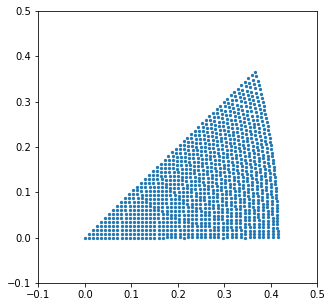

In [138]:
def grid_to_xy(grid):
    from orix.quaternion.rotation import Rotation
    from orix.vector.vector3d import Vector3d
    from orix.projections import StereographicProjection
    s = StereographicProjection(pole=-1)
    rotations_regular =  Rotation.from_euler(np.deg2rad(grid))
    rot_reg_test = rotations_regular*Vector3d.zvector()
    x, y = s.vector2xy(rot_reg_test)
    return x, y

fig, ax1 = plt.subplots(1, figsize=(5, 5))
ax1.scatter(*grid_to_xy(grid), s = 5)
ax1.set_xlim(-0.1, 0.5)
ax1.set_ylim(-0.1, 0.5)

In [139]:
from diffsims.libraries.structure_library import StructureLibrary
from diffsims.generators.diffraction_generator import DiffractionGenerator
from diffsims.generators.library_generator import DiffractionLibraryGenerator
import diffpy
structure_aus = diffpy.structure.loadStructure("Data/austeniteLP.cif")

(<AxesSubplot:>, <matplotlib.collections.PathCollection at 0x14feac9a0>)

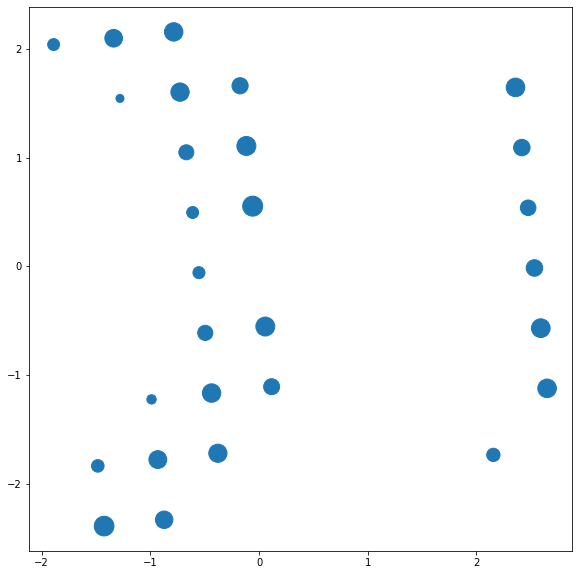

In [141]:
# diffraction generator controls how the patterns will be simulated
diff_gen = DiffractionGenerator(accelerating_voltage=200,
                                #scattering_params="lobato",
                                scattering_params=None,
                                shape_factor_model="linear",
                                minimum_intensity = 1e-10,
                               )
test = diff_gen.calculate_ed_data(
    structure_aus,
    3,
    rotation = (90, 4, 6),
    with_direct_beam = False,
    max_excitation_error = 0.04,
    # shape_factor_width = 0.05,  # in the linear case unnecessary
)
test.plot(size_factor = 100)

In [142]:
# experimental values necessary to scale the simulations
half_width_image = experimental_data.axes_manager["kx"].size//2
diffraction_scale = experimental_data.axes_manager["kx"].scale
reciprocal_radius = np.sqrt(2)*half_width_image*diffraction_scale

In [143]:
# list of phase names, list of structures, list of orientation grids to simulate
library_phases = StructureLibrary(["steel"], [structure_aus], [grid])
lib_gen = DiffractionLibraryGenerator(diff_gen)
diff_lib = lib_gen.get_diffraction_library(library_phases,
                                           calibration=diffraction_scale,
                                           reciprocal_radius=reciprocal_radius,
                                           half_shape=(half_width_image, half_width_image),
                                           with_direct_beam=False,
                                           max_excitation_error=0.05)

(<AxesSubplot:>, <matplotlib.collections.PathCollection at 0x1517f7ca0>)

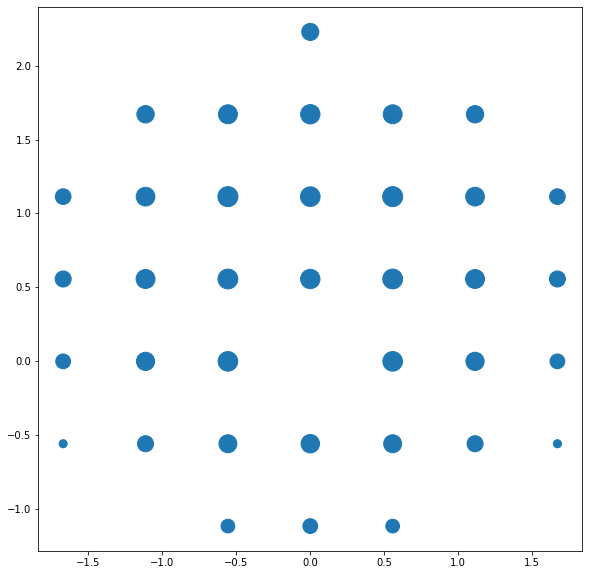

In [144]:
diff_lib["steel"]["simulations"][1].plot(100)

In [145]:
diff_lib.pickle_library("data/austenite_library.pickle")

# Matching and correlating

In [355]:
from diffsims.libraries.diffraction_library import load_DiffractionLibrary
# diff_lib = load_DiffractionLibrary('./Data/phase_template_library.pickle', safety=True)
# diff_lib = load_DiffractionLibrary('data/austenite_library.pickle', safety=True)

In [20]:
from pyxem.utils import indexation_utils as iutls
from pyxem.utils import plotting_utils as putls
from pyxem.utils import polar_transform_utils as ptutls

In [104]:
from pyxem.utils import expt_utils as eutls

In [266]:
from importlib import reload
reload(iutls)
reload(putls)
reload(ptutls)

<module 'pyxem.utils.polar_transform_utils' from '/Users/nielscautaerts/Documents/PythonProjects/FORKS/pyxem/pyxem/utils/polar_transform_utils.py'>

# Single image, single pattern
Finding the best-fit in-plane angle

Text(0, 0.5, 'Correlation')

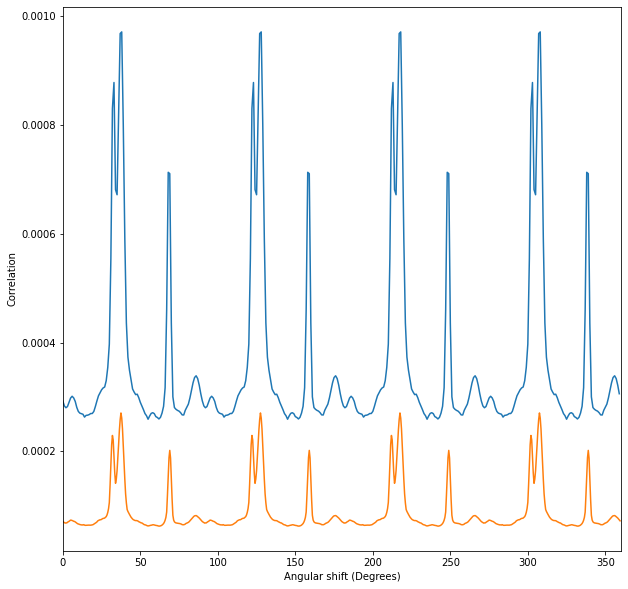

In [146]:
# pull out a random image and simulation
image = experimental_data.inav[0,0].data
simulation_test = diff_lib["steel"]["simulations"][0]

a, c = iutls.get_in_plane_rotation_correlation(
    image,
    simulation_test,
    intensity_transform_function=None,
    delta_r = 1,
    delta_theta = 1,
    max_r = None,
    find_direct_beam = True,
    direct_beam_position = None,
    normalize_image=True,
    normalize_template=True,
)

fig, ax = plt.subplots()
ax.plot(a, c)
ax.plot(*iutls.get_in_plane_rotation_correlation(image, simulation_test, delta_r = 0.1, delta_theta = 0.5,
                                                 find_direct_beam=True,
                                                 normalize_image=True, normalize_template=True))
ax.set_xlim(0, 360)
ax.set_xlabel("Angular shift (Degrees)")
ax.set_ylabel("Correlation")

(<AxesSubplot:>,
 <matplotlib.collections.PathCollection at 0x1563a4ca0>)

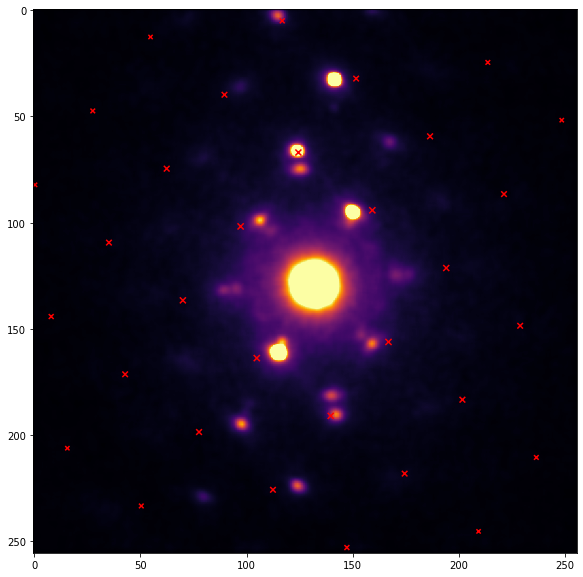

In [149]:
putls.plot_template_over_pattern(image, simulation_test,
                                 #in_plane_angle=0,
                                 in_plane_angle=a[np.argmax(c)],
                                 coordinate_system = "cartesian", 
                                 size_factor = 10, vmax=2000, 
                                 max_r = 200,
                                 find_direct_beam=True,
                                 cmap = "inferno"
                                )

# Single image, entire library
Finding the best angles and corresponding correlations for a list of simulations

In [216]:
simulations = diff_lib["steel"]["simulations"]

# these determine the granularity of the in-plane rotation matching
delta_r = 1
delta_theta = 1 
max_r = None
intensity_transform_function = None
find_direct_beam = True
direct_beam_position = None
normalize_image = True
normalize_templates = True

# only calculate match between radially integrated image and templates
fast_cors = iutls.correlate_library_to_pattern_fast(
    image, simulations, delta_r, delta_theta, max_r, intensity_transform_function, find_direct_beam,
    direct_beam_position, normalize_image, normalize_templates,
)

# these determine how many patterns are fully indexed
frac_keep = 1 
n_keep = None

# if frac_keep < 1 or 1 < n_keep < number of templates then indexation will be performed on the
# templates in "indexes" that have the highest "fast" correlation
indexes, angles, corrs, angles_m, corrs_m = iutls.correlate_library_to_pattern(
    image, simulations, frac_keep, n_keep, delta_r, delta_theta, max_r,
    intensity_transform_function, find_direct_beam, direct_beam_position,
    normalize_image, normalize_templates,
)

Text(0.5, 1.0, 'Mirrored angles')

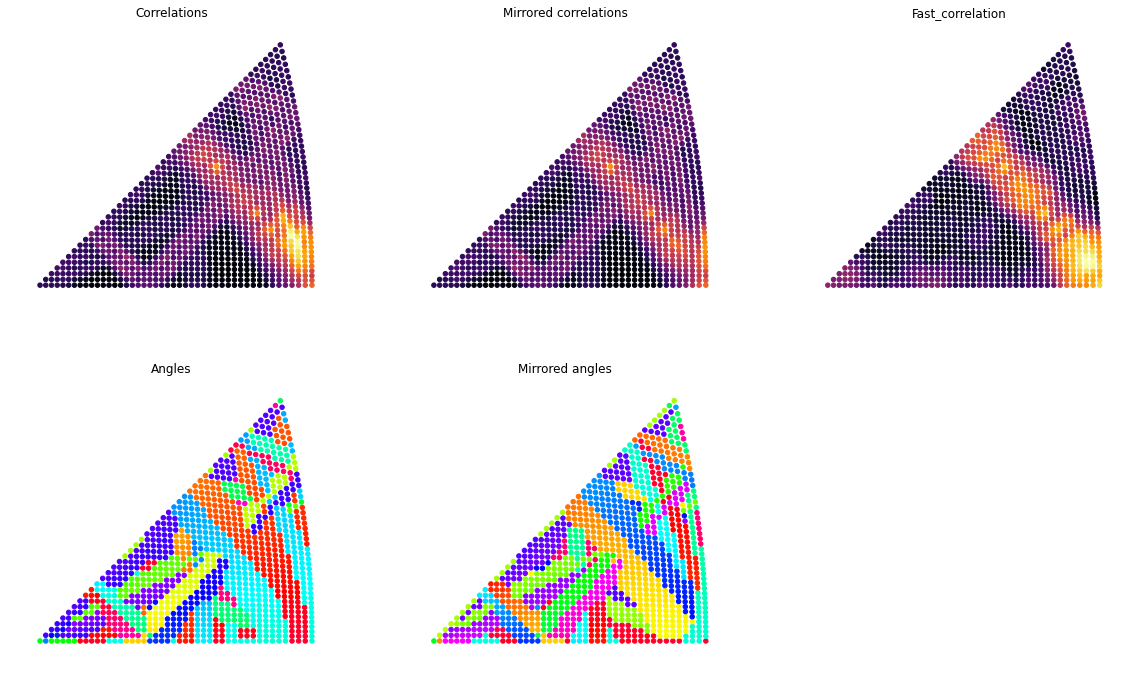

In [217]:
fig, ax = plt.subplots(ncols = 3, nrows = 2, figsize = (20, 12))

x, y = grid_to_xy(grid)

ax = ax.ravel()
for i in ax:
    i.set_xlim(-0.05, 0.45)
    i.set_ylim(-0.05, 0.4)
    i.axis("off")
    i.set_aspect("equal")
    
s = 20

# to ensure the same color scale on mirror and non-mirror
all_cors = np.stack([corrs, corrs_m])
vmin = all_cors.min()
vmax = all_cors.max()

ax[0].scatter(x[indexes], y[indexes], s = s, c = corrs, cmap = "inferno", vmin = vmin, vmax = vmax)
ax[0].set_title("Correlations")
ax[1].scatter(x[indexes], y[indexes], s = s, c = corrs_m, cmap = "inferno", vmin = vmin, vmax = vmax)
ax[1].set_title("Mirrored correlations")
ax[2].scatter(x, y, s = s, c = fast_cors, cmap = "inferno")
ax[2].set_title("Fast_correlation")
ax[3].scatter(x[indexes], y[indexes], s = s, c = angles, cmap = "hsv")
ax[3].set_title("Angles")
ax[4].scatter(x[indexes], y[indexes], s = s, c = angles_m, cmap = "hsv")
ax[4].set_title("Mirrored angles")

Getting on the n best answers (indexing)

In [218]:
n_best = 5
indices_n, angles_n, correlations_n, signs_n = iutls.get_n_best_matches(image,
                                                 simulations,
                                                 n_best,
                                                 frac_keep,
                                                 n_keep,
                                                 delta_r,
                                                 delta_theta,
                                                 max_r,
                                                 intensity_transform_function,
                                                 find_direct_beam,
                                                 direct_beam_position,
                                                 normalize_image,
                                                 normalize_templates,
                                                )
# signs tells you whether the solution is in the upper (1) or mirrored half (-1)

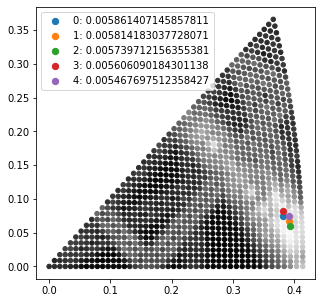

In [219]:
fig, ax = plt.subplots(figsize = (5, 5))

ax.scatter(x[indexes], y[indexes], s = s, c = corrs, cmap = "Greys_r", vmin = vmin, vmax = vmax)
for j, i in enumerate(indices_n):
    ax.scatter(x[i], y[i], s = s*2, label = f"{j}: {correlations_n[j]}")
ax.legend()

# Indexing a dataset with a library

In [183]:
file_location = "Data/sample_with_g.hspy"
data_file = hs.load(file_location, lazy=False)

/Users/nielscautaerts/Documents/PythonProjects/FORKS/hyperspy/hyperspy/misc/utils.py:493: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn('Use of the `binned` attribute in metadata is '
/Users/nielscautaerts/Documents/PythonProjects/FORKS/hyperspy/hyperspy/io.py:516: UserWarning: Loading old file version. The binned attribute has been moved from metadata.Signal to axis.is_binned. Setting this attribute for all signal axes instead.
  warnings.warn('Loading old file version. The binned attribute '


In [184]:
data_file.axes_manager

<Axes manager, axes: (25, 26|256, 256)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |     25 |      0 |   3e+02 |       2 |     nm 
               y |     26 |      0 | 1.9e+02 |       2 |     nm 
---------------- | ------ | ------ | ------- | ------- | ------ 
              kx |    256 |        |    -1.6 |   0.013 | $A^{-1}$ 
              ky |    256 |        |    -1.6 |   0.013 | $A^{-1}$

In [185]:
# centering of the dataset must be performed separately and before!
# the change is in-place applied to the dataset
data_file.center_direct_beam(method='blur',
                             sigma = 1,
                             half_square_width=20,
                             #return_shifts=True,
                            )

[########################################] | 100% Completed |  1.2s


In [220]:
frac_keep = 0.5

result = iutls.index_dataset_with_template_rotation(data_file,
                                                    diff_lib,
                                                    phases = ["steel"],
                                                    n_best = n_best,
                                                    frac_keep = frac_keep,
                                                    n_keep = n_keep,
                                                    delta_r = delta_r,
                                                    delta_theta = delta_theta,
                                                    max_r = max_r,
                                                    intensity_transform_function=intensity_transform_function,
                                                    normalize_images = normalize_image,
                                                    normalize_templates=normalize_templates,
                                                    chunks="auto",
                                                    )

[########################################] | 100% Completed |  2min 23.4s


# Visualizing the data
At present visualisation capabilities in orix are still somewhat limited so it is recommended to write out
the result to CTF format and analyze further with MTEX. Here are some hacky ways to get a quick visual.

In [221]:
result["steel"].keys()

dict_keys(['template_index', 'orientation', 'correlation', 'mirrored_template'])

In [222]:
solution = result["steel"]["orientation"]
cor_index = result["steel"]["correlation"]

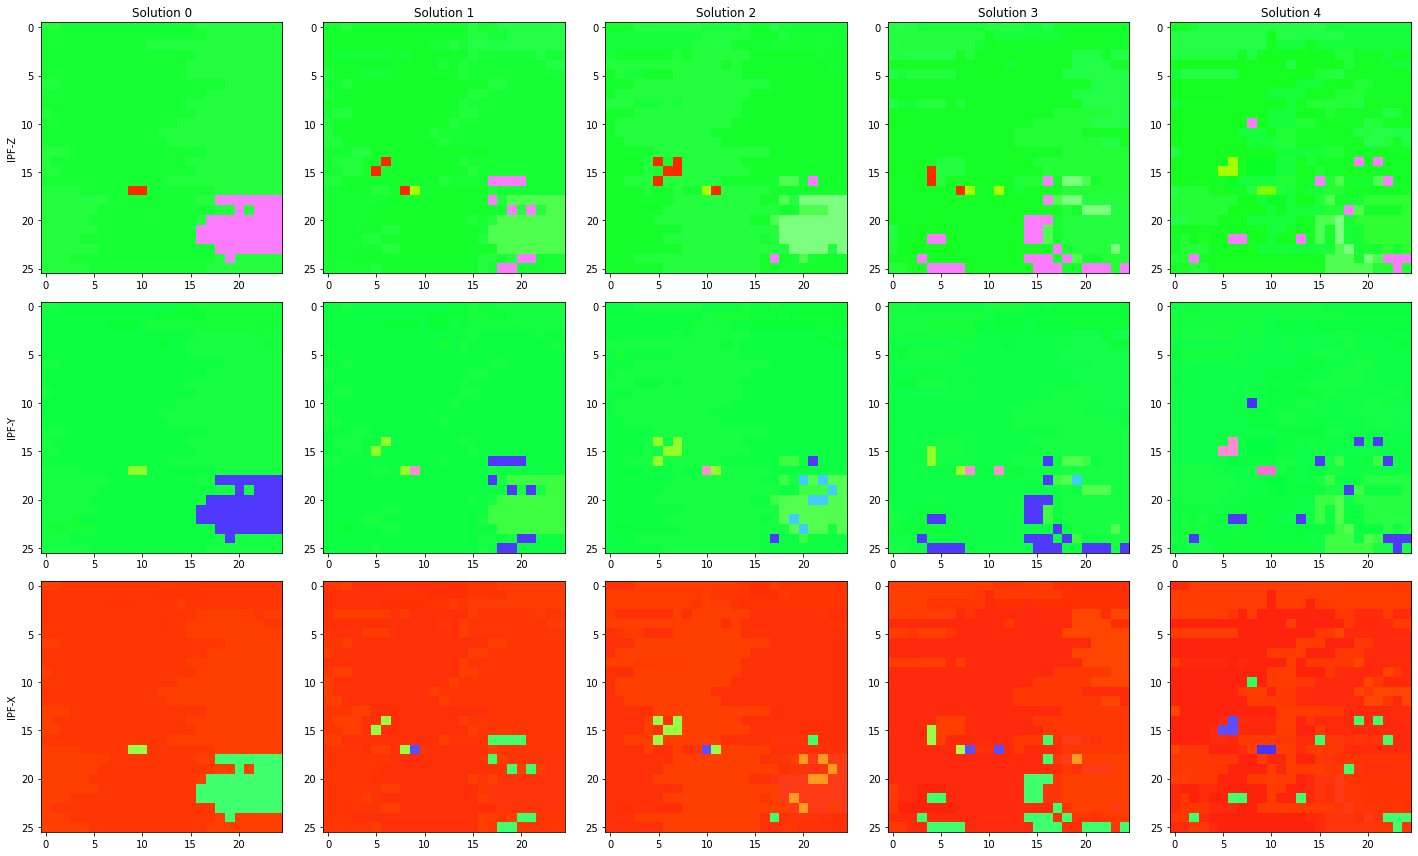

In [225]:
# presently IPF coloring is not part of orix yet and may be in v0.7.0
# we use this semi-hacky way to color the dataset

import matplotlib.colors as mcolors
from orix.projections import StereographicProjection

# map onto the fundamental zone
def to_fundamental(data_sol):
    data_sol = np.abs(data_sol)
    data_sol = np.sort(data_sol, axis=-1)
    column = data_sol[...,0].copy()
    data_sol[..., 0] = data_sol[...,1]
    data_sol[..., 1] = column
    return data_sol


def get_ipf_color(vectors):
    # the following column vectors should map onto R [100], G [010], B[001], i.e. the identity. So the inverse of 
    # this matrix maps the beam directions onto the right color vector
    color_corners = np.array([[0, 1/np.sqrt(2), 1/np.sqrt(3)],
                              [0, 0, 1/np.sqrt(3)],
                              [1, 1/np.sqrt(2), 1/np.sqrt(3)]])
    color_corners = np.array([[0, 1, 1],
                              [0, 0, 1],
                              [1, 1, 1]])
    color_mapper = np.linalg.inv(color_corners)

    # a bit of wrangling
    data_sol = to_fundamental(vectors.data)
    flattened = data_sol.reshape(np.product(data_sol.shape[:-1]), 3).T
    rgb_mapped = np.dot(color_mapper, flattened)
    rgb_mapped = np.abs(rgb_mapped / rgb_mapped.max(axis=0)).T
    rgb_mapped = rgb_mapped.reshape(data_sol.shape)
    return rgb_mapped
    
from orix.quaternion.rotation import Rotation
from orix.vector.vector3d import Vector3d

# draw IPF - Z (row 1), IPF - Y (row 2), IPF - Z (row 3)
fig, ax = plt.subplots(ncols = solution.shape[2], nrows = 3, figsize = (20, 12))

for i in range(solution.shape[2]):
    solution_vectors_z = Rotation.from_euler(np.deg2rad(solution[:,:,i,:]))*Vector3d.zvector()    
    solution_vectors_y = Rotation.from_euler(np.deg2rad(solution[:,:,i,:]))*Vector3d.yvector()    
    solution_vectors_x = Rotation.from_euler(np.deg2rad(solution[:,:,i,:]))*Vector3d.xvector()    
    ax[0, i].set_title(f"Solution {i}")
    ax[0, i].imshow(get_ipf_color(solution_vectors_z))
    ax[1, i].imshow(get_ipf_color(solution_vectors_y))
    ax[2, i].imshow(get_ipf_color(solution_vectors_x))

ax[0,0].set_ylabel("IPF-Z")
ax[1,0].set_ylabel("IPF-Y")
ax[2,0].set_ylabel("IPF-X")

fig.tight_layout()

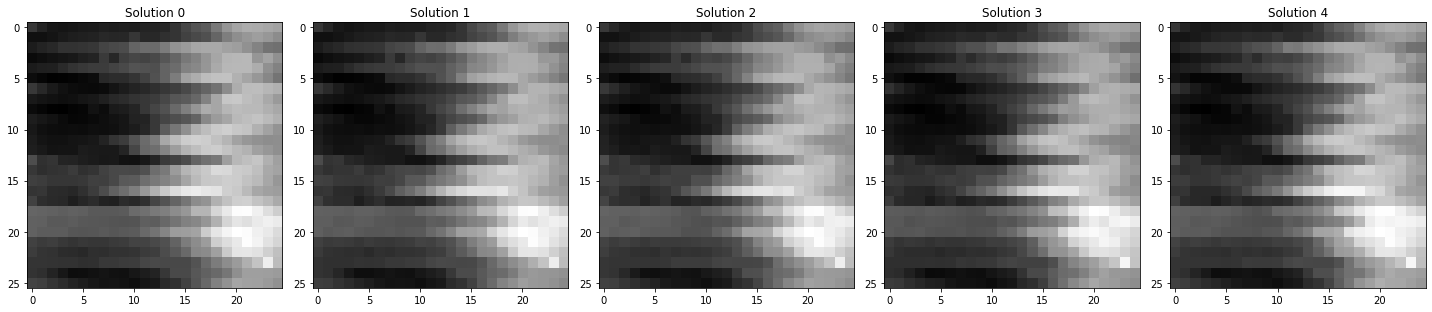

In [226]:
# draw IPF - Z (row 1), IPF - Y (row 2), IPF - Z (row 3)
fig, ax = plt.subplots(ncols = solution.shape[2], figsize = (20, 12))

for i in range(solution.shape[2]):
    # plot the correlation index on top
    ax[i].imshow(cor_index[:,:,i])
    ax[i].set_title(f"Solution {i}")

fig.tight_layout()

In [ ]:
from numba import